<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/04-exotic-fruit-classifier/fruits_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TropicTaste Exotic Fruit Classification — KNN Model  

    👨‍💻 Developed as part of the AI Engineering Master – Week 3


This notebook demonstrates how to build and evaluate a **K-Nearest Neighbors (KNN)** classifier to predict the type of exotic fruit based on numeric physical characteristics. The goal is to automate and improve the accuracy of the fruit classification process currently done manually.

---

## Project Highlights

The project covers the full machine learning workflow:

- Load and preprocess a dataset of exotic fruits with numeric features.
- Handle missing values, encode categorical targets, and scale features.
- Perform exploratory data analysis (EDA) with visualizations.
- Train a baseline KNN classifier.
- Optimize hyperparameters (`k`, distance metric, weights) using `GridSearchCV`.
- Evaluate model performance with cross-validation, accuracy metrics, and confusion matrix.
- Visualize results including accuracy trends and PCA projections.

---

## Key Goals

- Automate fruit classification to improve operational efficiency.
- Reduce human errors in the sorting process.
- Optimize model accuracy with proper tuning and validation.
- Provide clear visual interpretation of results and model behavior.

---

## Notebook Contents

1. Data loading and inspection  
2. Exploratory Data Analysis (EDA)  
3. Preprocessing
4. Baseline KNN training  
5. Hyperparameter tuning with GridSearchCV  
6. Model evaluation and visualization  
7. Conclusions and next steps

---

🔗 GitHub Repository: [tropictaste-fruit-classification](<repo-url>)


In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn and ML tools
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_validate, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Stats and VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# **Utilities functions**

### This section contains general-purpose helper functions to support exploratory data analysis, statistical diagnostics, and feature evaluation in machine learning workflows.


In [2]:
def plot_distribution():
  # target column
  target_col = 'Frutto'

  # not considering target column
  feature_cols = [col for col in fruits_df.columns if col != target_col][:4]  # take only first 4

  # setting styles
  sns.set(style="whitegrid")

  # Create a 2x2 grid of subplots
  fig, axes = plt.subplots(2, 2, figsize=(10, 8))
  axes = axes.flatten()

  # Loop through each feature column and plot
  for i, col in enumerate(feature_cols):
      sns.histplot(fruits_df[col], kde=True, ax=axes[i])
      axes[i].set_title(f"Distribution of {col}")
      axes[i].set_xlabel(col)
      axes[i].set_ylabel("Frequency")

  plt.tight_layout()
  plt.show()

In [3]:
def show_correlation_matrix(selected_df: pd.DataFrame) -> None:
    """
    Displays a heatmap of the correlation matrix.
    Args:
        selected_df (pd.DataFrame): DataFrame (usually with numeric columns) for correlation plot.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(selected_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

In [4]:
def calculate_vif(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates Variance Inflation Factor (VIF) for each feature in the DataFrame.
    Identifies multicollinearity where VIF > 5 or 10 indicates potential issue.
    Args:
        df (pd.DataFrame): DataFrame with only numerical features.
    Returns:
        pd.DataFrame: Feature names and respective VIF values, sorted descending.
    """
    vif = pd.DataFrame()
    vif['feature'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif.sort_values(by='VIF', ascending=False)

# Data loading and inspection


In [5]:
dataset_url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv'

In [6]:
fruits_df = pd.read_csv(dataset_url)
fruits_df.head()

,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
0,Mela,86.40,89.68,8.69,9.61,2.41
1,Mela,77.58,73.45,6.49,7.20,3.87
2,Mela,81.95,81.66,6.40,9.09,2.88
3,Mela,66.33,36.71,6.78,8.21,2.55
4,Mela,56.73,75.69,5.78,9.15,3.88


In [7]:
fruits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Frutto                 500 non-null    object 
 1   Peso (g)               500 non-null    float64
 2   Diametro medio (mm)    500 non-null    float64
 3   Lunghezza media (mm)   500 non-null    float64
 4   Durezza buccia (1-10)  500 non-null    float64
 5   Dolcezza (1-10)        500 non-null    float64
dtypes: float64(5), object(1)
memory usage: 23.6+ KB


✅ There are 500 rows and 6 columns. The data types are float64 and object (which is the target).

In [8]:
# Checking for null
fruits_df.isna().sum()

,0
Frutto,0
Peso (g),0
Diametro medio (mm),0
Lunghezza media (mm),0
Durezza buccia (1-10),0
Dolcezza (1-10),0


✅ There are no null values.

In [9]:
fruits_df['Frutto'].unique()

array(['Mela', 'Banana', 'Arancia', 'Uva', 'Kiwi'], dtype=object)

In [10]:
# Encoding target
label_encoder = LabelEncoder()

fruits_df['Frutto'] = label_encoder.fit_transform(fruits_df['Frutto'])

✅ The values in the 'Frutto' column all seem correct (without duplicates like 'Mela' or 'mela').

# Exploratory Data Analysis (EDA)

# Showing correlation matrix

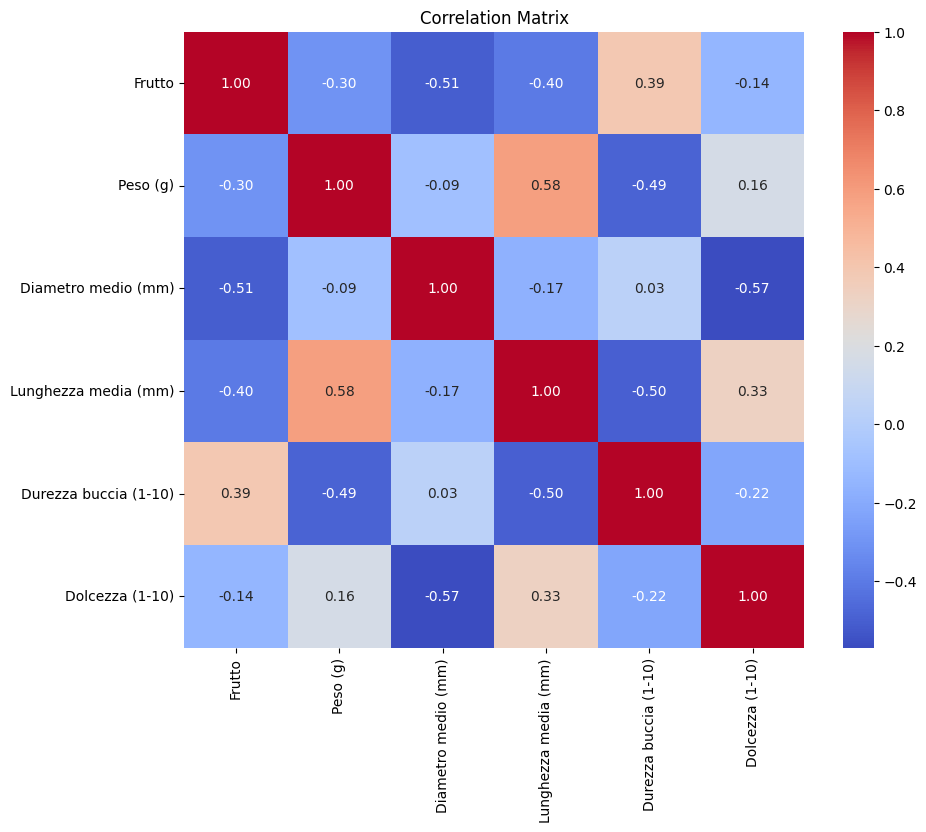

In [11]:
show_correlation_matrix(fruits_df)

In [12]:
# Drop target variable before computing VIF
calculate_vif(fruits_df.drop('Frutto', axis=1))

,feature,VIF
4,Dolcezza (1-10),10.158980
3,Durezza buccia (1-10),8.537871
2,Lunghezza media (mm),8.380725
0,Peso (g),6.088246
1,Diametro medio (mm),3.112181


In [13]:
fruits_df = fruits_df.drop(columns=['Dolcezza (1-10)', 'Durezza buccia (1-10)', ], axis=1)

In [14]:
# Drop target variable before computing VIF
calculate_vif(fruits_df.drop('Frutto', axis=1))

,feature,VIF
2,Lunghezza media (mm),5.897962
0,Peso (g),5.891664
1,Diametro medio (mm),1.911875


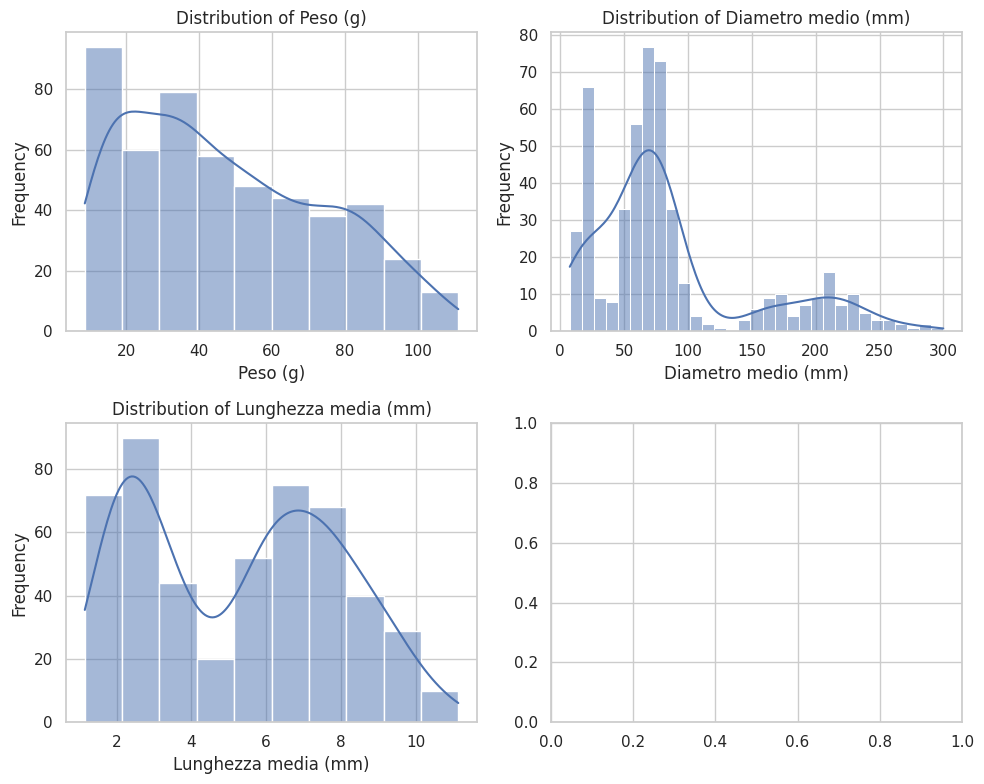

In [15]:
plot_distribution()

### Observations on Feature Distributions

- **Weight (g):**  
  The distribution is right-skewed with a long tail towards higher values. This indicates that most fruits have lower weights but there are some heavier outliers. Such asymmetry suggests considering a transformation (e.g., logarithmic or square root) to stabilize variance and make the data more normally distributed.

- **Average Diameter (mm):**  
  The distribution is multimodal, showing two distinct peaks: one cluster around smaller diameters and another around larger diameters. This might reflect the presence of different fruit types or size groups in the dataset. The distribution is not symmetric, so transformations or clustering-aware methods could be useful.

- **Average Length (mm):**  
  Another multimodal distribution with peaks at around 2-3 mm and 6-7 mm. Similar to diameter, it suggests heterogeneity in fruit sizes and non-normal distribution.

- **Peel Hardness (1-10):**  
  This is the only feature showing an approximately bell-shaped (normal) distribution. Given its symmetry, no transformation is likely needed for this variable.

### Implications for Data Processing

- For features with skewed or multimodal distributions (Weight, Diameter, Length), applying transformations like logarithm or square root can help reduce skewness and make the data more suitable for models sensitive to feature scale and distribution, such as K-Nearest Neighbors (KNN).

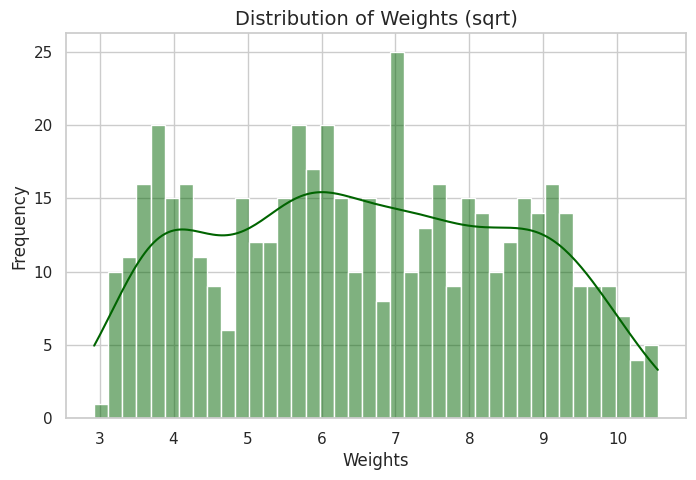

In [16]:
# Distribution of prices (log)
plt.figure(figsize=(8,5))
sns.histplot(np.sqrt(fruits_df['Peso (g)']), bins=40, kde=True, color='darkgreen')
plt.title('Distribution of Weights (sqrt)', fontsize=14)
plt.xlabel('Weights')
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

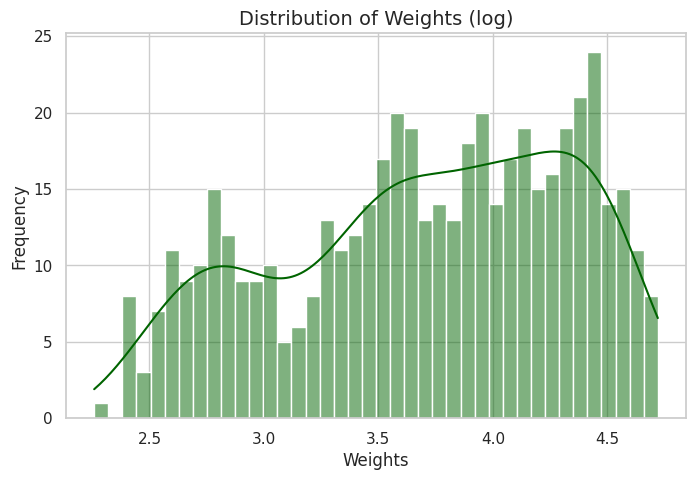

In [17]:
# Distribution of prices (log)
plt.figure(figsize=(8,5))
sns.histplot(np.log(fruits_df['Peso (g)'] + 1), bins=40, kde=True, color='darkgreen')
plt.title('Distribution of Weights (log)', fontsize=14)
plt.xlabel('Weights')
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Choice of Transformation for Numerical Features

After examining the distribution plots of the numerical features, the square root (sqrt) transformation appears more appropriate than the logarithmic (log) transformation for the following reasons:

- **Moderate Skewness**: The distributions are somewhat right-skewed but not extremely so. The sqrt transformation is milder and effectively reduces moderate skewness without overly compressing the data.
- **Preservation of Distribution Shape**: The sqrt transformation improves symmetry while preserving the relative differences among values better than log, which tends to compress large values more drastically.
- **Empirical Evidence**: Visual comparisons (before and after transformations) show that sqrt leads to more balanced and natural-looking distributions here.

In summary, applying the square root transformation to the skewed numerical features helps stabilize variance and makes the data more suitable for distance-based models like K-Nearest Neighbors, without the potentially excessive compression that the log transformation might cause.


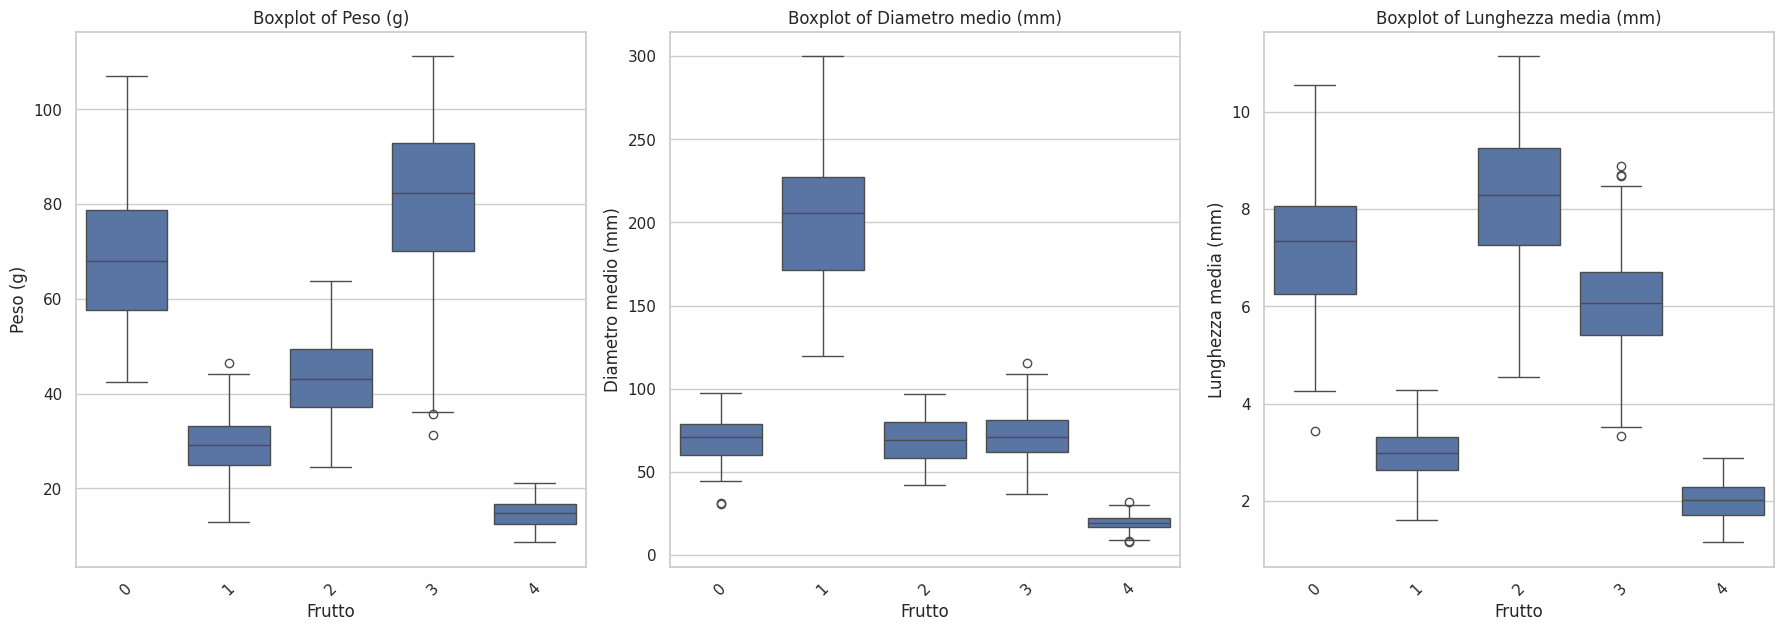

In [18]:
numerical_cols = ['Peso (g)', 'Diametro medio (mm)', 'Lunghezza media (mm)'] # , 'Dolcezza (1-10)', 'Durezza buccia (1-10)'
target_col = fruits_df['Frutto']

# 1. Boxplot di ogni variabile rispetto al target
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=target_col, y=col, data=fruits_df)
    plt.title(f'Boxplot of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Insights from the Boxplots

- **Weight (g):** Apples and bananas have higher average weights and greater variance compared to the other fruits. Grapes have the lowest and most compact weight distribution, while kiwis are intermediate.
- **Average Diameter (mm):** Bananas show the largest and most variable diameters. Apples, oranges, and kiwis have similar values, while grapes are clearly smaller.
- **Average Length (mm):** Kiwis are longest on average, followed by oranges and apples. Grapes and bananas are shorter.
- **Skin Hardness (1-10):** Skin hardness is relatively similar across fruits, though bananas tend to have slightly higher values. Apples and kiwis show less variation in skin hardness.
- **Sweetness (1-10):** Oranges are the sweetest on average. Apples and bananas are less sweet, while grapes and kiwis are intermediate.

# Preprocessing

In [19]:
# Cols transformations
fruits_df['Peso (g)'] = np.log(fruits_df['Peso (g)'])

In [20]:
fruits_df.head(4)

,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm)
0,3,4.458988,89.68,8.69
1,3,4.351310,73.45,6.49
2,3,4.406109,81.66,6.40
3,3,4.194642,36.71,6.78


Ho vals > 10 nella scala

In [21]:
#count = (fruits_df['Durezza buccia (1-10)'] > 10).sum()
#print(count)

Li clippo

In [22]:
#fruits_df['Durezza buccia (1-10)'] = fruits_df['Durezza buccia (1-10)'].clip(upper=10)


In [23]:
X = fruits_df.drop('Frutto', axis=1)
y = fruits_df['Frutto']

In [24]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [25]:
# Columns to scale (numeric non-binary)
cols_to_scale = ['Peso (g)','Diametro medio (mm)','Lunghezza media (mm)']

scaler = MinMaxScaler()

X_train_scaled_df = X_train.copy()
X_test_scaled_df = X_test.copy()

X_train_scaled_df[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled_df[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [26]:
X_train_scaled_df.head(7)

,Peso (g),Diametro medio (mm),Lunghezza media (mm)
43,0.910869,0.169791,0.424424
308,0.288261,0.043576,0.066066
258,0.893449,0.227938,0.591592
239,0.878788,0.252429,0.417417
327,0.305689,0.057942,0.022022
432,0.487136,0.177316,0.645646
376,0.123329,0.047202,0.126126


Controllo che i valori siano nel range post split

In [28]:
# count = (X_train_scaled_df['Durezza buccia (1-10)'] > 10).sum()
# print(count)


# Baseline KNN training  


In [29]:
knn = KNeighborsClassifier() # n_neighbor default is 5
knn.fit(X_train_scaled_df, y_train)

KNeighborsClassifier()

In [30]:
y_pred = knn.predict(X_test_scaled_df)

In [31]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100}%')

Accuracy: 81.33333333333333%


# Hyperparameter tuning with GridSearchCV  


In [32]:
n_samples = fruits_df.shape[0]

# Define the model
knn = KNeighborsClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_neighbors': list(range(1, int(np.sqrt(n_samples)) + 1)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Setup GridSearchCV with 5-fold cross-validation and accuracy scoring
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model on the scaled training data
grid_search.fit(X_train_scaled_df, y_train)

# Extract the best cross-validation accuracy and convert to percentage
best_accuracy = grid_search.best_score_ * 100

# storing best params
best_params = grid_search.best_params_

# Model evaluation and visualization  


In [33]:
# Print the best hyperparameter and the corresponding accuracy
print(f"Best params: {grid_search.best_params_}")
print(f"Best k: {grid_search.best_params_['n_neighbors']}")
print(f"Training accuracy with tuning: {best_accuracy:.2f}%")

Best params: {'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'distance'}
Best k: 21
Training accuracy with tuning: 83.76%


In [34]:
# Use the best estimator to predict the test set
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled_df)

In [35]:
y_train_pred = best_knn.predict(X_train_scaled_df)
print(classification_report(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        84
           2       1.00      1.00      1.00        86
           3       1.00      1.00      1.00        87
           4       1.00      1.00      1.00        83

    accuracy                           1.00       425
   macro avg       1.00      1.00      1.00       425
weighted avg       1.00      1.00      1.00       425



In [36]:
# Print the classification report for the test set predictions
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.82      0.60      0.69        15
           1       1.00      1.00      1.00        16
           2       0.65      0.93      0.76        14
           3       0.73      0.62      0.67        13
           4       1.00      1.00      1.00        17

    accuracy                           0.84        75
   macro avg       0.84      0.83      0.82        75
weighted avg       0.85      0.84      0.84        75



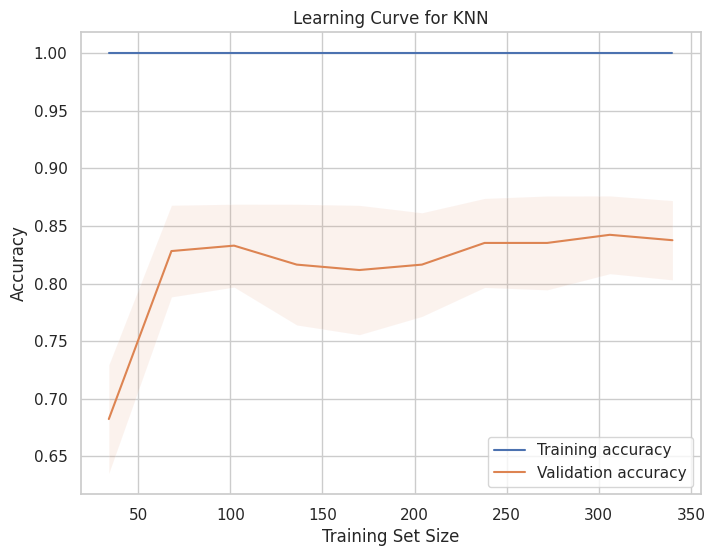

In [37]:
knn_best = KNeighborsClassifier(**best_params)

train_sizes, train_scores, val_scores = learning_curve(
    knn_best, X_train_scaled_df, y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Calculate mean and std for train and val scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, label='Validation accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

plt.title('Learning Curve for KNN')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Conclusions and next steps